## SVM 各种内核的介绍

本节讲述如何使用 tensorflow 实现各种内核：

- 线性内核：$K(x1, x2) = t(x1) * x2$
- 高斯内核（RBF）：$K(x1, x2) = exp(-gamma * abs(x1 - x2)^2)$

好了，开码：

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
# Start computational graph session.
sess = tf.Session()

本例，我们将产生伪非线性数据。我们生成的是同心环数据。

In [3]:
# Generate non-lnear data
(x_vals, y_vals) = datasets.make_circles(n_samples=350, factor=.5, noise=.1)
y_vals = np.array([1 if y==1 else -1 for y in y_vals])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

接下来声明批量大小（对 SVM 来说要大些），创建占位符，声明 svm 模型变量。

In [4]:
# Declare batch size
batch_size = 350

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# Create variables for svm
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

接下来将应用内核。注意 Linear kenerl 被注释掉了。取消注释可使用线性内核。

In [5]:
# Apply kernel
# Linear Kernel
# my_kernel = tf.matmul(x_data, tf.transpose(x_data))

# Gaussian (RBF) kernel
gamma = tf.constant(-50.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

接下来创建 SVM 模型和损失函数。

In [6]:
# Compute SVM Model
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

上面创建的是训练的内核，接下来创建用于测试/预测的内核。

In [7]:
# Create Prediction Kernel
# Linear prediction kernel
# my_kernel = tf.matmul(x_data, tf.transpose(prediction_grid))

# Gaussian (RBF) prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

然后创建预测操作来使用内核进行点集分类。

In [8]:
prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

现在声明优化函数和变量初始化

In [9]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.002)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

接下来开始训练 SVM 模型。随机选择一个批量的点集来进行训练。然后计算损失和精确度。

In [10]:
# Training loop
loss_vec = []
batch_accuracy = []
for i in range(1000):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                             y_target: rand_y,
                                             prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%250==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #250
Loss = 19.6193
Step #500
Loss = -5.59713
Step #750
Loss = -12.3386
Step #1000
Loss = -11.5047


为使我们的绘图更加好看，我们创建一个细网格来运行我们的模型并获得预测值。（和 sci-kit learn 中的 SVM 绘图相似）

In [11]:
# Create a mesh to plot points in
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data: rand_x,
                                                   y_target: rand_y,
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

绘制结果

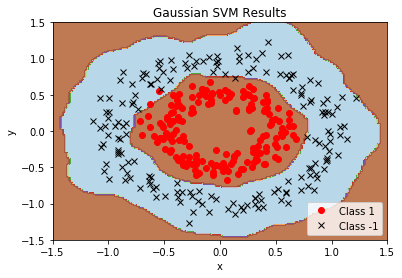

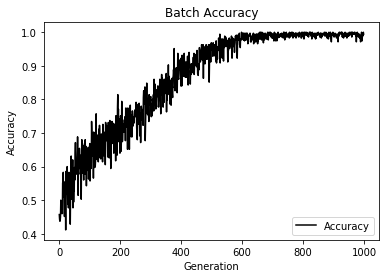

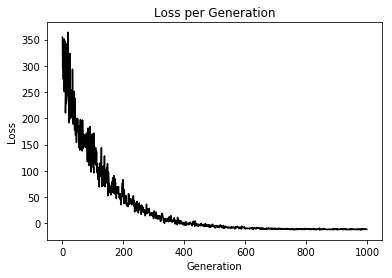

In [12]:
# Plot points and grid
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='Class 1')
plt.plot(class2_x, class2_y, 'kx', label='Class -1')
plt.title('Gaussian SVM Results')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.ylim([-1.5, 1.5])
plt.xlim([-1.5, 1.5])
plt.show()

# Plot batch accuracy
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()